In [1]:
# Organizing imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Make numpy printouts easier to read
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.6.0-dev20210510


In [2]:
# Downloading the data
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [3]:
# Performing Data Cleansing
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [4]:
# Dropping the rows with unknowns
dataset = dataset.dropna()

In [5]:
# One-hot encoding for 'Origin' column as it is categorical in reality
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


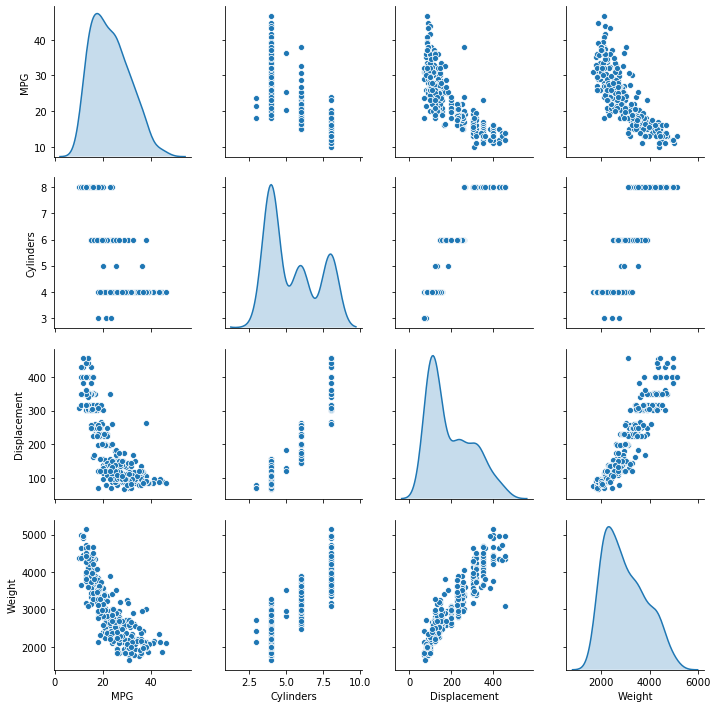

In [6]:
# Creating Train and Test dataset
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

# Inspecting the data
# Note pairplot shows obvious relationships between data. 
# If there is no relationship a good model cannot be really built.
sns.pairplot(train_dataset[['MPG','Cylinders','Displacement','Weight']],
            diag_kind='kde')

In [7]:
# Describing the statistics
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [8]:
# Separating the target value, the "label", from the features. 
# This label is the value that you will train the model to predict
train_features = train_dataset.copy()
test_features  = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels  = test_features.pop('MPG')

In [9]:
# Normalization of dataset as every feature has a wide and different range
# Inspecting range
train_dataset.describe().transpose()[['mean','std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


In [10]:
# The Normalization layer
normalizer = preprocessing.Normalization()
# calling adapt to adapt our data to the normalization layer
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())
# PS: When the layer is called it returns the input data, with each feature independently normalized:
first = np.array(train_features[:1])
with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())


[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]
First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


In [11]:
# We will be building a shallow neural network of Linear Regression for simplicity
# Then we will be builing a Deep Neural Network to perform exact same task

# Single variable linear regression model (MPG vs Horsepower)

# Normaliation layer
horsepower = np.array(train_features['Horsepower'])
horsepower_normalizer = preprocessing.Normalization(input_shape=[1,])
horsepower_normalizer.adapt(horsepower)
# Building the sequential model
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])
horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [12]:
# Compiling the model
horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

# Fitting the model
history = horsepower_model.fit(
    train_features['Horsepower'], train_labels,
    epochs=100,
    # supress logging
    verbose=0,
    # calculating validation results on 20% of the training data
    validation_split = 0.2)

# visualizing the model's training progress using the stats stored in 
# history object
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.807292,4.197367,95
96,3.804423,4.188330,96
97,3.806320,4.199443,97
98,3.804229,4.178086,98
99,3.802955,4.186752,99


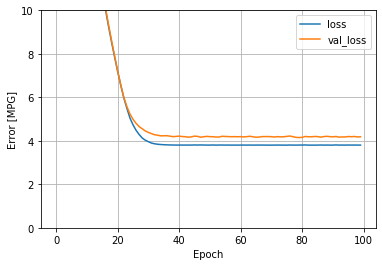

In [13]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0,10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)
plot_loss(history)

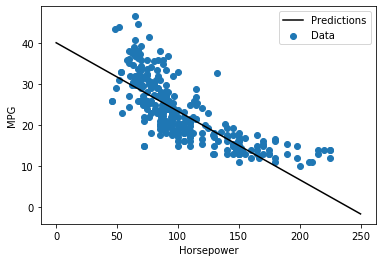

In [14]:
# Evaluating the model on the test set
test_results = {}
test_results['horssepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

# visualizing model's predictions as a function of the input
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

def plot_horsepower(x, y):
    plt.scatter(train_features['Horsepower'], train_labels, label='Data')
    plt.plot(x,y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()
plot_horsepower(x,y)

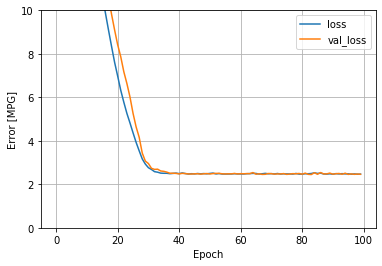

In [15]:
# Multiple inputs
# Building the sequential model
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

# Compiling the model
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

# Fitting the model
history = linear_model.fit(
    train_features, train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # calcuate validation results on 20% of the training data
    validation_split=0.2)

# collecting results
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)
# visualizing the model's training progress using the stats stored in 
# history object
plot_loss(history)

In [16]:
# The Deep Neural Network Model
# This section implements single-input and multiple-input DNN models.
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation= 'relu'),
        layers.Dense(64, activation= 'relu'),
        layers.Dense(1)
    ])
    
    model.compile(loss='mean_absolute_error',
                 optimizer=tf.keras.optimizers.Adam(0.001))
    return model


In [17]:
# starting with a DNN model for a single input: "Horsepower"
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)
dnn_horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


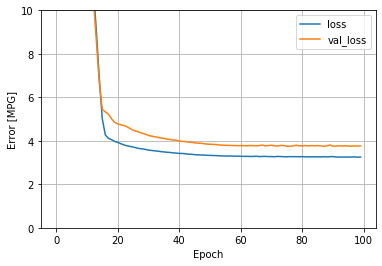

In [18]:
history = dnn_horsepower_model.fit(
    train_features['Horsepower'], train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)
plot_loss(history)

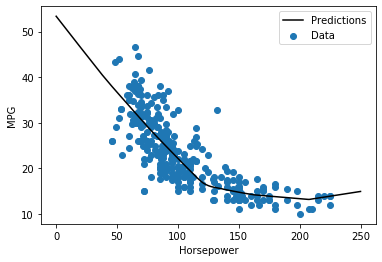

In [19]:
x = tf.linspace(0.0,250,251)
y = dnn_horsepower_model.predict(x)
plot_horsepower(x,y)

In [20]:
test_results['dnn_horse_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

In [21]:
# Full model
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense_5 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


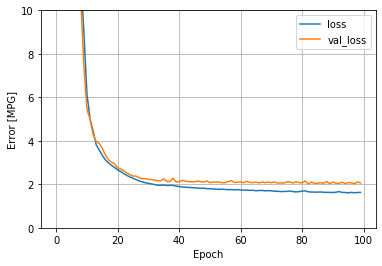

In [22]:
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100 )
plot_loss(history)

In [23]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [24]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horssepower_model,3.646328
linear_model,2.491367
dnn_horse_model,2.872215
dnn_model,1.765547


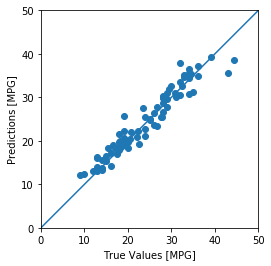

In [25]:
test_predictions = dnn_model.predict(test_features).flatten()
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0,50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)

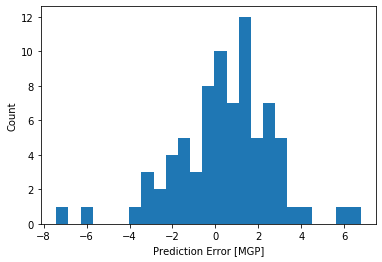

In [26]:
# error distribution
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MGP]')
_ = plt.ylabel('Count') 

In [27]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model\assets


In [28]:
reloaded = tf.keras.models.load_model('dnn_model')
test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)


In [29]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horssepower_model,3.646328
linear_model,2.491367
dnn_horse_model,2.872215
dnn_model,1.765547
reloaded,1.765547
